In [2]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import Model
from sklearn.utils import validation
from tensorflow.python.keras.engine import training
import random
import argparse
import warnings
from logging import error
import tensorflow as tf
import librosa
import os
import numpy as np
from SpeechModel import SpeechModel

In [3]:
class SpeechModel:
    def __init__(self, num_output_classes) -> None:
        self.num_output_classes = num_output_classes

    def getRAVDESS(self) -> Model:
        """Returns a tensorflow model that is according to specifications of the baseline CNN model in the paper."""
        input_layer = L.Input(shape=(187, 1))

        cnn1 = L.Conv1D(256, (4))(input_layer)
        batch_norm1 = L.BatchNormalization()(cnn1)
        relu1 = L.ReLU()(batch_norm1)
        

        cnn2 = L.Conv1D(128, (4))(relu1)
        relu2 = L.ReLU()(cnn2)
        dropout1 = L.Dropout(0.1)(relu2)
        batch_norm2 = L.BatchNormalization()(dropout1)

        max_pool1 = L.MaxPool1D(8)(batch_norm2)

        conv3 = L.Conv1D(128, (4))(max_pool1)
        relu3 = L.ReLU()(conv3)
        conv4 = L.Conv1D(128, (4))(relu3)
        relu4 = L.ReLU()(conv4)
        conv5 = L.Conv1D(128, (4))(relu4)
        batch_norm4 = L.BatchNormalization()(conv5)
        relu5 = L.ReLU()(batch_norm4)
        dropout2 = L.Dropout(0.2)(relu5)

        conv6 = L.Conv1D(128, (4))(dropout2)
        flatten = L.Flatten()(conv6)
        dropout3 = L.Dropout(0.2)(flatten)

        output_logits = L.Dense(self.num_output_classes)(dropout3)
        batch_norm5 = L.BatchNormalization()(output_logits)
        softmax = L.Softmax()(batch_norm5)
        model = Model(inputs=[input_layer], outputs=[softmax])
        optimizer = tf.keras.optimizers.RMSprop(1e-5)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        model.compile(optimizer=optimizer, loss=loss)

        return model

    def getEmoDB(self) -> Model:
        """Returns a tensorflow model that is according to specifications of the EmoDB model A in the paper."""
        input_layer = L.Input(shape=(193, 1))

        cnn1 = L.Conv1D(256, (5))(input_layer)
        batch_norm1 = L.BatchNormalization()(cnn1)
        relu1 = L.ReLU()(batch_norm1)

        cnn2 = L.Conv1D(128, (5))(relu1)
        relu2 = L.ReLU()(cnn2)
        dropout1 = L.Dropout(0.1)(relu2)

        max_pool1 = L.MaxPool1D(8)(dropout1)

        conv3 = L.Conv1D(128, (4))(max_pool1)
        batch_norm2 = L.BatchNormalization()(conv3)
        relu3 = L.ReLU()(batch_norm2)
        dropout2 = L.Dropout(0.2)(relu3)

        flatten = L.Flatten()(dropout2)

        output_logits = L.Dense(self.num_output_classes)(flatten)
        softmax = L.Softmax()(output_logits)
        model = Model(inputs=[input_layer], outputs=[softmax])
        optimizer = tf.keras.optimizers.RMSprop(1e-5)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        model.compile(optimizer=optimizer, loss=loss)

        return model

    def getIEMOCAP(self) -> Model:
        """Returns a model that is same as EmoDB model in most senses, except dropout value before MaxPool layer is increased and model is compiled with Adam optimizer instead."""
        input_layer = L.Input(shape=(193, 1))

        cnn1 = L.Conv1D(256, (5))(input_layer)
        batch_norm1 = L.BatchNormalization()(cnn1)
        relu1 = L.ReLU()(batch_norm1)

        cnn2 = L.Conv1D(128, (5))(relu1)
        relu2 = L.ReLU()(cnn2)
        dropout1 = L.Dropout(0.2)(relu2)
        batch_norm2 = L.BatchNormalization()(dropout1)

        max_pool1 = L.MaxPool1D(8)(batch_norm2)

        conv3 = L.Conv1D(128, (5))(max_pool1)
        relu3 = L.ReLU()(conv3)
        conv4 = L.Conv1D(128, (5))(relu3)
        relu4 = L.ReLU()(conv4)
        conv5 = L.Conv1D(128, (5))(relu4)
        batch_norm4 = L.BatchNormalization()(conv5)
        relu5 = L.ReLU()(batch_norm4)
        dropout2 = L.Dropout(0.2)(relu5)

        conv6 = L.Conv1D(128, (5))(dropout2)
        flatten = L.Flatten()(conv6)
        dropout3 = L.Dropout(0.2)(flatten)

        output_logits = L.Dense(self.num_output_classes)(dropout3)
        batch_norm5 = L.BatchNormalization()(output_logits)
        softmax = L.Softmax()(batch_norm5)
        model = Model(inputs=[input_layer], outputs=[softmax])
        optimizer = tf.keras.optimizers.Adam(1e-5)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        model.compile(optimizer=optimizer, loss=loss)

        return model



In [4]:
EMOTION_DICT_EMODB = {
    "W": "anger",
    "L": "boredom",
    "E": "disgust",
    "A": "fear",
    "F": "happiness",
    "T": "sadness",
    "N": "Neutral",
}

EMOTION_DICT_RAVDESS = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}


def process_audio_clip(file_path, label):
    file_path = file_path.numpy()
    audio, sr = librosa.load(file_path)
    mfcc = np.mean(librosa.feature.mfcc(audio, sr, n_mfcc=40).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(audio, sr).T, axis=0)
    chromagram = np.mean(librosa.feature.chroma_stft(audio, sr).T, axis=0)
    spectral = np.mean(librosa.feature.spectral_contrast(audio, sr).T, axis=0)
    #tonnetz = np.mean(librosa.feature.tonnetz(audio, sr).T, axis=0)
    extracted_features = tf.concat([mfcc, mel, chromagram, spectral], axis=0)
    return extracted_features, label


def get_dataset(
    training_dir="./train_data_speech/",
    label_dict=EMOTION_DICT_RAVDESS,
    validation_dir=None,
    val_split=0.2,
    batch_size=128,
    random_state=42,
    cache=False,
):
    """
    Creates a `tf.data.Dataset` object.
    Arguments:
    training_dir : String
    label_dict : dictionary with labels
    """

    def decompose_label(file_path: str):
        return label_to_int[file_path.split("-")[2]]

    def tf_wrapper_process_audio_clip(file_path, label):
        extracted_features, label = tf.py_function(
            process_audio_clip, [file_path, label], [tf.float32, tf.int32]
        )
        extracted_features = tf.expand_dims(extracted_features, -1)
        return extracted_features, label

    file_path_list = os.listdir(training_dir)
    label_to_int = dict({(key, i) for i, key in enumerate(label_dict.keys())})
    labels = [decompose_label(file_path) for file_path in file_path_list]

    # Split into train and val sets
    if validation_dir is None:
        if val_split > 0:
            from sklearn.model_selection import train_test_split

            file_path_list = [
                os.path.join(training_dir, path) for path in file_path_list
            ]
            train_paths, val_paths, train_labels, val_labels = train_test_split(
                file_path_list, labels, test_size=val_split, random_state=random_state
            )
    else:
        train_paths = file_path_list
        train_labels = file_path_list
        val_paths = os.listdir(validation_dir)
        val_labels = [decompose_label(file_path) for file_path in val_paths]
        val_paths = [os.path.join(training_dir, path) for path in val_paths]

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

    train_ds = train_ds.map(
        tf_wrapper_process_audio_clip, num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.map(
        tf_wrapper_process_audio_clip, num_parallel_calls=tf.data.AUTOTUNE
    )

    if cache:
        train_ds = train_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
        val_ds = val_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    else:
        train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds


def create_model(num_output_classes, model_type="ravdess"):
    speechModel = SpeechModel(num_output_classes)
    if model_type.lower() == "emodb":
        model = speechModel.getEmoDB()
    elif model_type.lower() == "ravdess":
        model = speechModel.getRAVDESS()
    elif model_type.lower() == "iemocap":
        model = speechModel.getIEMOCAP()
    else:
        print("Model_type unknown. Please use one of \[emoDB, Ravdess, IEMOCAP\]")
        return error

    return model


In [5]:
# This is required to avoid librosa's warning about n_fft being too large. I don't know how to fix the issue the warning is trying to fix since
# Specifying a smaller n_ftt doesn't seem to fix it.
warnings.filterwarnings("ignore", category=UserWarning)

# Defaults

EPOCHS = 250
BATCH_SIZE = 128
model_type = "Ravdess"
NUM_LABELS = None
# Argument Parser
"""
help_message = "Check the documentation available at https://www.github.com/AnkushMalaker/speech-emotion-recognition for more info on usage."
parser = argparse.ArgumentParser(description=help_message)

parser.add_argument("epochs", type=int, help="Specify number of epochs")

parser.add_argument(
    "-B",
    "--batch_size",
    type=int,
    help="Default batch size is 32. Reduce this if the data doesn't fit in your GPU.",
)

parser.add_argument(
    "-C",
    "--cache",
    action="store_true",
    help="Default behaviour is to not use cahce. Caching greatly speeds up the training after 1 epoch but may require a lot of Memory.",
)

parser.add_argument(
    "-LR", "--learning_rate", type=float, help="Default Learning rate is 1e-5."
)

parser.add_argument("--train_dir", help="Default data directory is ./train_data")

parser.add_argument(
    "--val_dir",
    help="Default behaviour is to take given split from train_dir to do validation. Specify the split using --val_split",
)

parser.add_argument(
    "--val_split", type=float, help="Default val_split is 0.2 of train data"
)

parser.add_argument(
    "--model_type",
    help='Specifies the specific architecture to be used. Check README for more info. Defaults to "Ravdess".',
)

# This logic has to be improved to adapt to other datasets mentioned in the paper.
# Or the whole code has to be split into different sections for each, like train_emodb.py, train_xyz,... etc.
# Currently not handling this argument
parser.add_argument("--num_labels", help="Specify number of labels")

parser.add_argument(
    "--random_state",
    type=int,
    help="Specify random state for consistency in experiments. Use -1 to randomize.",
)

args = parser.parse_args()

EPOCHS = args.epochs

print(EPOCHS)
if args.cache:
    CACHE = True
else:
    CACHE = False

if args.batch_size:
    BATCH_SIZE = args.batch_size
else:
    BATCH_SIZE = 32

if args.train_dir:
    train_dir = args.train_dir
else:
    train_dir = "./train_data"

if args.val_dir:
    val_dir = args.val_dir
else:
    val_dir = None

if args.random_state == -1:
    RANDOM_STATE = random.randint(0, 10000)
else:
    RANDOM_STATE = 42

if args.val_split:
    val_split = args.val_split
else:
    val_split = 0.2

if args.model_type:
    model_type = model_type
else:
    model_type = "ravdess"

if args.num_labels:
    NUM_LABELS = args.num_labels
else:
    NUM_LABELS = 8
"""

train_ds, val_ds = get_dataset(
    training_dir="./train_data_speech/",
    validation_dir=None,
    val_split=0.2,
    batch_size=BATCH_SIZE,
    random_state=42,
    cache=False,
)

model = create_model(8, model_type)

#ESCallback = tf.keras.callbacks.EarlyStopping(
    #patience=2, restore_best_weights=True, verbose=3
#)

# Add checkpoint callback
model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=None,
    epochs=EPOCHS,
)

model.save(f"saved_model/{EPOCHS}_trained_model")

Epoch 1/250
9/9 [==============================] - 105s 12s/step - loss: 2.3182 - val_loss: 2.0793
Epoch 2/250
9/9 [==============================] - 98s 11s/step - loss: 2.2185 - val_loss: 2.0742
Epoch 3/250
9/9 [==============================] - 93s 11s/step - loss: 2.1826 - val_loss: 2.0701
Epoch 4/250
9/9 [==============================] - 109s 13s/step - loss: 2.1470 - val_loss: 2.0664
Epoch 5/250
9/9 [==============================] - 91s 10s/step - loss: 2.1075 - val_loss: 2.0630
Epoch 6/250
9/9 [==============================] - 109s 12s/step - loss: 2.0599 - val_loss: 2.0597
Epoch 7/250
9/9 [==============================] - 100s 11s/step - loss: 2.0446 - val_loss: 2.0563
Epoch 8/250
9/9 [==============================] - 91s 10s/step - loss: 2.0202 - val_loss: 2.0537
Epoch 9/250
9/9 [==============================] - 100s 11s/step - loss: 2.0342 - val_loss: 2.0507
Epoch 10/250
9/9 [==============================] - 88s 10s/step - loss: 1.9854 - val_loss: 2.0476
Epoch 11/250
9

9/9 [==============================] - 97s 11s/step - loss: 1.6570 - val_loss: 1.7674
Epoch 84/250
9/9 [==============================] - 84s 9s/step - loss: 1.6241 - val_loss: 1.7633
Epoch 85/250
9/9 [==============================] - 87s 10s/step - loss: 1.6048 - val_loss: 1.7596
Epoch 86/250
9/9 [==============================] - 98s 11s/step - loss: 1.6305 - val_loss: 1.7587
Epoch 87/250
9/9 [==============================] - 83s 9s/step - loss: 1.6274 - val_loss: 1.7569
Epoch 88/250
9/9 [==============================] - 86s 10s/step - loss: 1.6336 - val_loss: 1.7547
Epoch 89/250
9/9 [==============================] - 96s 11s/step - loss: 1.6225 - val_loss: 1.7518
Epoch 90/250
9/9 [==============================] - 85s 9s/step - loss: 1.6169 - val_loss: 1.7494
Epoch 91/250
9/9 [==============================] - 86s 10s/step - loss: 1.6098 - val_loss: 1.7499
Epoch 92/250
9/9 [==============================] - 94s 11s/step - loss: 1.6066 - val_loss: 1.7487
Epoch 93/250
9/9 [========

Epoch 165/250
9/9 [==============================] - 110s 12s/step - loss: 1.4393 - val_loss: 1.6559
Epoch 166/250
9/9 [==============================] - 110s 12s/step - loss: 1.4502 - val_loss: 1.6557
Epoch 167/250
9/9 [==============================] - 109s 12s/step - loss: 1.4252 - val_loss: 1.6555
Epoch 168/250
9/9 [==============================] - 109s 12s/step - loss: 1.4109 - val_loss: 1.6587
Epoch 169/250
9/9 [==============================] - 109s 12s/step - loss: 1.4268 - val_loss: 1.6590
Epoch 170/250
9/9 [==============================] - 111s 13s/step - loss: 1.4084 - val_loss: 1.6566
Epoch 171/250
9/9 [==============================] - 110s 12s/step - loss: 1.4101 - val_loss: 1.6554
Epoch 172/250
9/9 [==============================] - 110s 12s/step - loss: 1.4025 - val_loss: 1.6502
Epoch 173/250
9/9 [==============================] - 110s 12s/step - loss: 1.4131 - val_loss: 1.6522
Epoch 174/250
9/9 [==============================] - 109s 12s/step - loss: 1.3920 - val_los

9/9 [==============================] - 102s 12s/step - loss: 1.2496 - val_loss: 1.5764
Epoch 247/250
9/9 [==============================] - 81s 9s/step - loss: 1.2698 - val_loss: 1.5748
Epoch 248/250
9/9 [==============================] - 88s 10s/step - loss: 1.2457 - val_loss: 1.5770
Epoch 249/250
9/9 [==============================] - 97s 11s/step - loss: 1.2431 - val_loss: 1.5723
Epoch 250/250
9/9 [==============================] - 96s 11s/step - loss: 1.2518 - val_loss: 1.5733


INFO:tensorflow:Assets written to: saved_model/250_trained_model\assets


INFO:tensorflow:Assets written to: saved_model/250_trained_model\assets


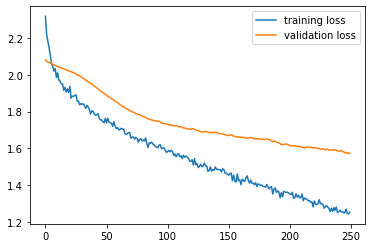

In [7]:
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

tf.Tensor(
[6 4 1 1 4 7 1 2 2 7 5 5 3 7 6 0 1 5 7 4 4 2 1 7 2 3 2 0 0 1 6 6 2 6 7 7 2
 1 6 6 2 6 5 6 6 2 2 7 3 3 1 6 3 4 6 2 7 4 2 4 0 5 4 2 4 1 5 1 2 3 5 6 2 6
 6 7 1 7 7 1 6 2 3 5 2 1 4 4 5 1 2 1 5 3 5 7 5 4 1 4 6 7 2 2 0 1 3 1 2 5 2
 3 5 3 1 3 2 2 3 5 5 1 4 5 3 4 3 5], shape=(128,), dtype=int32)
tf.Tensor(
[6 7 1 1 4 7 1 2 0 7 6 5 3 7 2 0 1 5 7 7 4 2 1 6 2 3 0 1 0 1 6 4 0 6 6 7 2
 1 6 6 2 6 2 2 0 3 2 7 3 3 1 6 3 3 6 2 7 4 2 4 1 5 4 2 4 1 5 0 2 3 5 6 1 6
 7 7 1 7 7 1 6 7 3 5 7 2 4 4 5 1 2 0 5 7 5 7 5 7 1 1 7 7 2 2 0 1 2 1 7 5 2
 3 5 3 5 3 7 2 3 5 5 6 7 5 7 4 3 5], shape=(128,), dtype=int64)


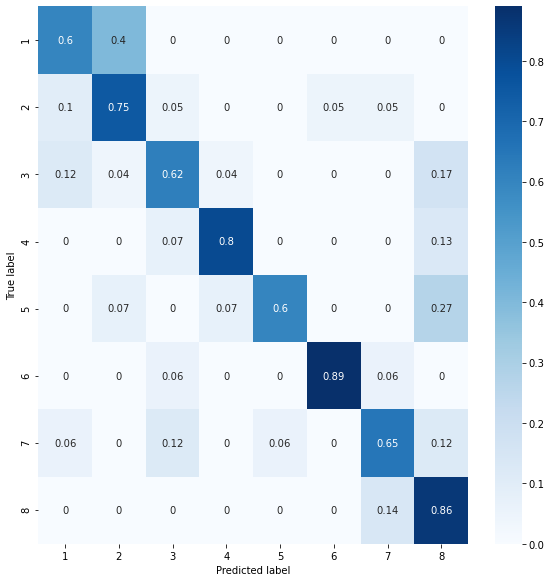

In [6]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import pandas as pd
import seaborn as sns

all_Y = []
all_Yp = []
classes= [1,2,3,4,5,6,7,8]

batch_count = 1

for batch in train_ds:
    if batch_count == 0: break
    batch_count -= 1
        
    X, Y = batch
    Yp_raw = model.call(X)
    Yp = tf.argmax(Yp_raw, axis=-1)
    
    all_Y = tf.concat([all_Y, Y], 0)
    all_Yp = tf.concat([all_Yp, Yp], 0)
    
print(all_Y)
print(all_Yp)

confusion = tf.math.confusion_matrix(all_Y, all_Yp, 8).numpy()

con_mat_norm = np.around(confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [1]:
import warnings
warnings.filterwarnings('ignore')